In [23]:
suppressPackageStartupMessages({
  library(cowplot)
  library(dplyr)
  library(dataorganizer)
  library(devtools)
  library(cellAdmix)
  library(ggplot2)
  library(readr)
  devtools::load_all()
})

suppressMessages({
  load_arial_font()
})

theme_set(theme_bw())

ℹ Loading cellAdmixNotebooks


In [3]:
# load data
cell_annot <- prepare_nsclc_metadata(reps='one')
df <- prepare_nsclc_transcript_data(cell_annot,reps='one')
so_rna <- prepare_nsclc_scrna()

In [5]:
base_dir <- CachePath('nsclc_scaled_dat11/')

k_joint <- c(5,15,20,30)
k_ct <- c(5)

In [7]:
# load NMF and CRF results
res <- load_nmf_crf_multi(k_joint, k_ct, base_dir)
all_nmf <- res[[1]]
crf_all <- res[[2]]

In [8]:
# load saved enrichment results
enr_res_all <- file.path(base_dir,'enrich_results.rds') %>% readRDS()

In [9]:
# load and extract bridge results
all_ctypes <- unique(cell_annot$celltype)
bridge_res_all <- extract_bridge_multi(all_nmf,all_ctypes=all_ctypes,
                                       dir=base_dir,bridge_pthresh=.1,
                                       bridge_adj_pvals=FALSE)

In [12]:
# load and extract bridge results
memb_res_all <- extract_memb_multi(
  all_nmf,all_ctypes=all_ctypes, dir=base_dir,
  memb_pthresh=.01, memb_adj_pvals=FALSE
)

In [13]:
fp_checks <- check_fp_multi(df,cell_annot,crf_all,enr_res_all=enr_res_all,
                            bridge_res_all=bridge_res_all,memb_res_all=memb_res_all,
                            do_clean=TRUE,knn_k=100,median_thresh=.2)
annot_res_all <- fp_checks[[1]]
orig_nms_all <- fp_checks[[2]]

write_rds(fp_checks, file.path(base_dir,'fp_checks.rds'))

In [14]:
# compute cell adj mat for scores calculation
df$cell_type <- df$celltype
sc_ctypes <- unique(so_rna$cell_type)
df_ct_match <- df[df$cell_type %in% sc_ctypes,]
cell_adj_df <- estimate_cell_adjacency(df_ct_match, random.shift=1e-2, n.cores=30)

In [15]:
# now to get genes to exclude based on comparing gene-gene correlations across datasets
so_spatial <- get_counts_meta_seurat(df)
so_spatial <- NormalizeData(so_spatial)
common_genes <- intersect(rownames(so_rna), rownames(so_spatial))
length(common_genes)
so_spatial %<>% subset(features=common_genes)
so_rna %<>% subset(features=common_genes)
cor_cors <- estimate_correlation_preservation(so_spatial[['RNA']]$data, so_rna[['RNA']]$data)

Normalizing layer: counts



[1] 958

In [16]:
dbl_score_params <- list(
  signal_thres=0.4,
  exclude_genes=names(cor_cors)[cor_cors<.2],
  p.c=.25,
  min.expr.frac=0.05,
  exclude.cell.types=NULL,
  max.prob.high=0.1
)

In [17]:
# # identify genes to exclude which likely have strong background signal
bg_cl_fracs <- get_bg_cl_fracs(dbl_score_params,df,so_rna,cell_adj_df,n_samp=1000,n.cores=20)

Normalizing layer: counts



In [18]:
frac_cutoff <- .1
more_g_exclude <- lapply(1:length(bg_cl_fracs),function(i) {
  x <- bg_cl_fracs[[i]]
  ct <- names(bg_cl_fracs)[i]
  g_rm <- names(x)[x<frac_cutoff]
  if (length(g_rm)==length(x)) {
    message(paste0('All genes are removed for cell type ',ct,'. Reduce the frac_cutoff parameter.'))
  } else if (length(g_rm)>(.8*length(x))) {
    message(paste0('Over 80% of genes are removed for cell type ',ct,'. Reduce the frac_cutoff parameter.'))
  }
  return(g_rm)
})
names(more_g_exclude) <- names(bg_cl_fracs)
more_g_exclude$all <- dbl_score_params$exclude_genes
dbl_score_params$exclude_genes <- unique(unlist(more_g_exclude))

# checking how many got removed from each ctype
for (i in 1:length(bg_cl_fracs)) {
  x <- bg_cl_fracs[[i]]
  x_orig <- length(x)
  x <- names(x)
  x <- x[!(x %in% dbl_score_params$exclude_genes)]
  print(paste0('Fraction ME genes remaining in ',names(bg_cl_fracs)[i],':',round(length(x)/x_orig,3)))
}

Over 80% of genes are removed for cell type neutrophil. Reduce the frac_cutoff parameter.

Over 80% of genes are removed for cell type malignant. Reduce the frac_cutoff parameter.



[1] "Fraction ME genes remaining in DC:0.07"
[1] "Fraction ME genes remaining in endothelial:0.006"
[1] "Fraction ME genes remaining in macrophage:0.068"
[1] "Fraction ME genes remaining in plasmablast:0.076"
[1] "Fraction ME genes remaining in epithelial:0.046"
[1] "Fraction ME genes remaining in neutrophil:0.072"
[1] "Fraction ME genes remaining in fibroblast:0.02"
[1] "Fraction ME genes remaining in NK:0.081"
[1] "Fraction ME genes remaining in CD4+ T cells:0.079"
[1] "Fraction ME genes remaining in B cells:0.076"
[1] "Fraction ME genes remaining in malignant:0.037"
[1] "Fraction ME genes remaining in mast:0.068"
[1] "Fraction ME genes remaining in monocyte:0.064"
[1] "Fraction ME genes remaining in Treg:0.077"
[1] "Fraction ME genes remaining in CD8+ T cells:0.081"


In [19]:
# compute admixture probability scores
scores_final_df <- suppressWarnings(get_scores_multi(
  annot_res_all, orig_nms_all, dbl_score_params, df, so_rna, crf_all, cell_adj_df, n.cores=15
))

write_rds(scores_final_df, file.path(base_dir, 'scores_final_df.rds'))

Normalizing layer: counts



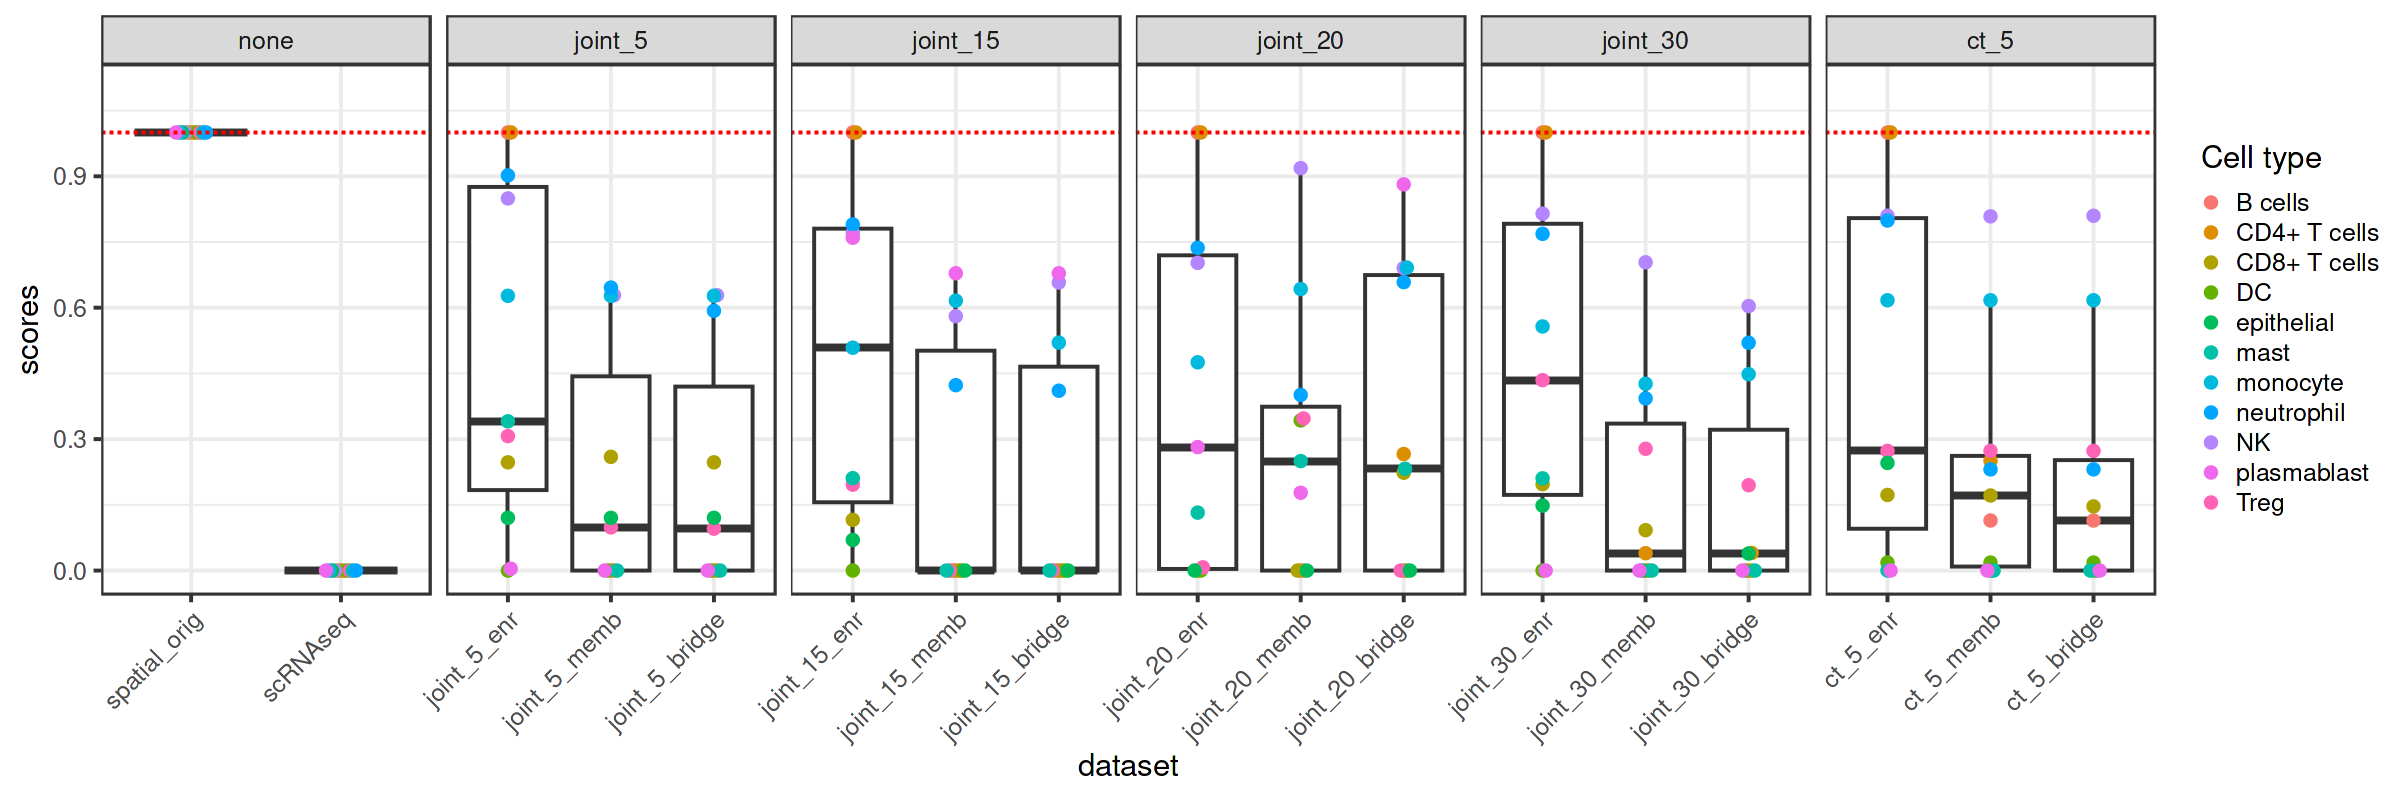

In [20]:
options(repr.plot.width = 12, repr.plot.height = 4, repr.plot.res = 200)

p <- plot_ct_av_norm_scores(scores_final_df,trim_level=.9,min_mean_thresh=1e-3)
p

In [21]:
res_nm <- 'joint_15_bridge'
res_nm_splt <- strsplit(res_nm,split='_')[[1]]
f_rm <- annot_res_all[[res_nm]]
crf_res <- crf_all[[paste0(res_nm_splt[[1]],'_',res_nm_splt[[2]])]]
scores_orig <- scores_final_df[scores_final_df$dataset=='spatial_orig',]
scores_cln <- scores_final_df[scores_final_df$dataset==res_nm,]

plts <- plot_cell_score_ratios(
  scores_orig,scores_cln,f_rm,df,crf_res,
  upper.lim=1.5,min.mean.thresh=1e-3
)

Picking joint bandwidth of 0.046



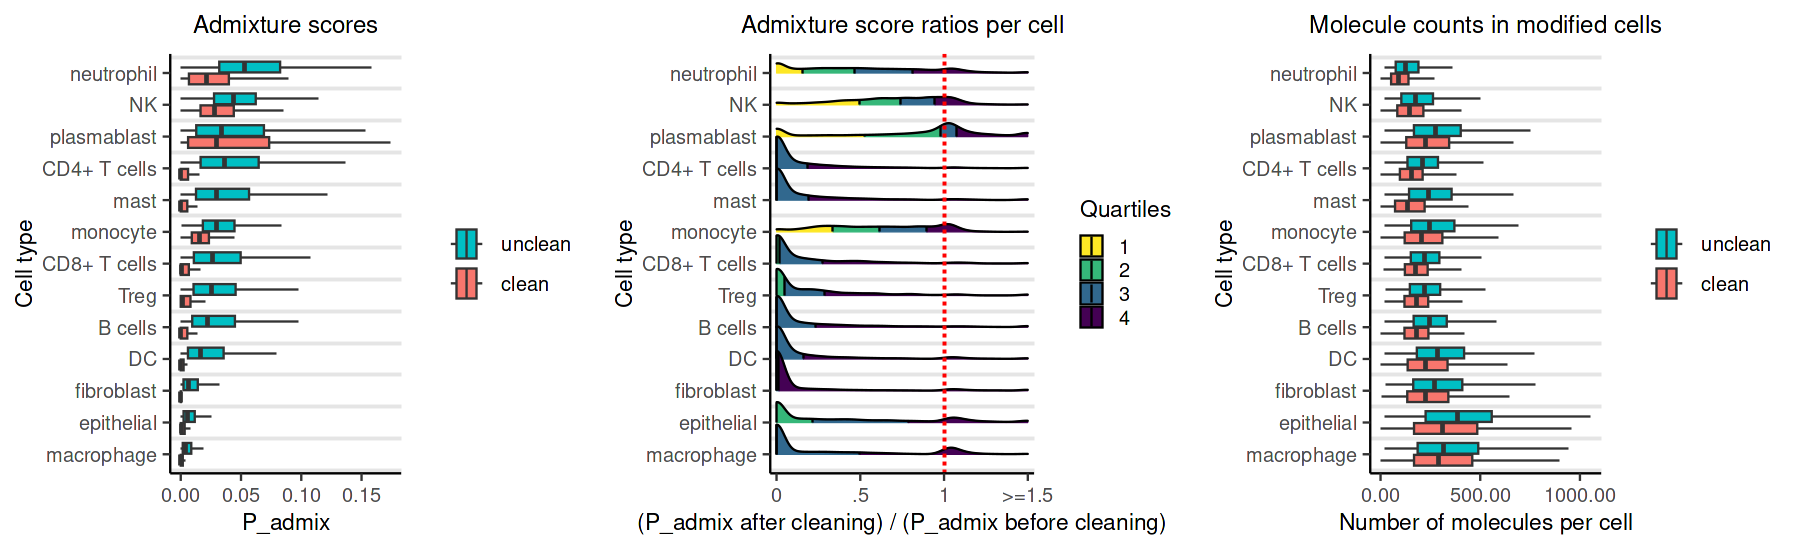

In [24]:
options(repr.plot.width = 9, repr.plot.height = 2.75, repr.plot.res = 200)
fig <- plot_grid(plotlist=plts[c(1,2,4)],nrow=1,align='h')
fig

In [25]:
pdf(OutputPath("nsclc_cell_score_ratios.pdf"), useDingbats=FALSE, width=9, height=2.75)
fig
dev.off()

png 
  2

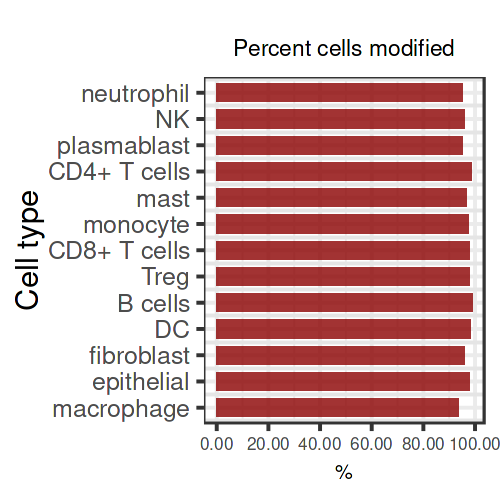

In [26]:
options(repr.plot.width = 2.5, repr.plot.height = 2.5, repr.plot.res = 200)
plts[[3]]

In [27]:
pdf(OutputPath("nsclc_pct_cells_cln.pdf"), useDingbats=FALSE, width=2.3, height=2)
plts[[3]]
dev.off()

png 
  2

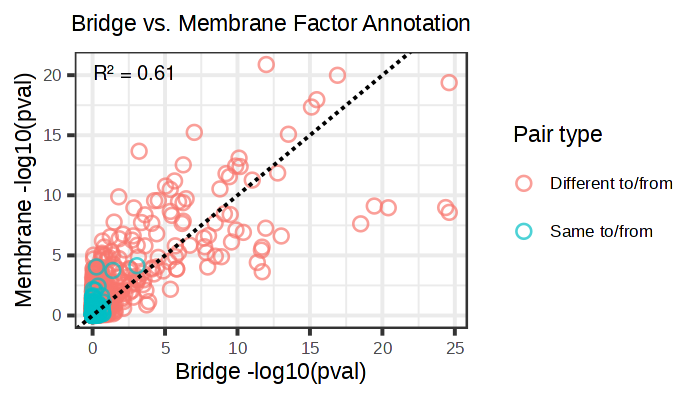

In [30]:
options(repr.plot.width = 3.5, repr.plot.height = 2, repr.plot.res = 200)

##### plotting comparison between bridge and membrane results
all_ctypes <- unique(cell_annot$celltype)

k <- 15
bridge_raw <- readRDS(paste0(base_dir,'bridge_joint_',k,'.rds'))
bridge_pv_mat <- extract_bridge_res(
  bridge_raw, all_ctypes, k, nmf.type='joint', p.thresh=.1,
  adj.pvals=FALSE, get.p.mat=TRUE
)

memb_raw <- readRDS(paste0(base_dir,'membrane_joint_',k,'.rds'))
memb_pv_mat <- extract_memb_res(
  memb_raw, all_ctypes, nmf.type='joint', p.thresh=.1,
  adj.pvals=FALSE, get.p.mat=TRUE
)

b_un <- unlist(bridge_pv_mat)
m_un <- unlist(memb_pv_mat)

### for labelling the diagonal elements
n <- nrow(bridge_pv_mat[[1]])
n2 <- n*n
diag_ndx_full <- sapply(1:length(bridge_pv_mat),function(j){
  diag_ndx <- sapply(1:n,function(i){
    ndx <- ((i-1)*n)+i
  })
  diag_ndx <- diag_ndx + (n2*(j-1))
  return(diag_ndx)
})

# tmp <- cbind.data.frame(c(bridge_pv_mat),c(memb_pv_mat))
tmp <- cbind.data.frame(c(b_un),c(m_un))
tmp$self_fact <- FALSE
tmp[diag_ndx_full,'self_fact'] <- TRUE

colnames(tmp)[1:2] <- c('bridge','membrane')
ndx_keep <- which(sapply(1:nrow(tmp),function(i){
  return(!any(is.na(tmp[i,])))
}))
tmp <- tmp[ndx_keep,]

tmp$self_fact <- sapply(tmp$self_fact,function(x) {
  if (x) {
    return('Same to/from')
  } else {
    return('Different to/from')
  }
})

# Fit a linear model
model <- lm(membrane ~ bridge, data = tmp)
r2 <- summary(model)$r.squared
p <- ggplot(tmp,aes(x=bridge,y=membrane,color=self_fact)) +
  geom_point(data=tmp[tmp$self_fact=='Different to/from',],alpha=.7,pch=21,size = 2) +
  geom_point(data=tmp[tmp$self_fact=='Same to/from',],alpha=.7,pch=21,size = 2) +
  geom_abline(intercept = 0, slope = 1, linetype = "dashed", color = "black") +
  ggtitle('Bridge vs. Membrane Factor Annotation') +
  xlab('Bridge -log10(pval)') +
  ylab('Membrane -log10(pval)') +
  labs(color = "Pair type") +
  annotate("text",
           x = min(tmp$bridge,na.rm=TRUE),
           y = max(tmp$membrane,na.rm=TRUE),
           label = paste("R² =", round(r2, 2)),
           hjust = 0,
           vjust = 1,
           size = 2.5) +
  theme_bw() +
  p_theme

p

In [31]:
pdf(OutputPath("nsclc_bridge_vs_memb.pdf"), useDingbats=FALSE, width = 3.5, height = 2)
p
dev.off()

png 
  2

In [34]:
devtools::load_all('~/segmentation-error-impact/cellAdmix/')

ℹ Loading cellAdmix


In [35]:
# plotting the bridge and membrane pvalues
k <- 15
bridge_raw <- readRDS(paste0(base_dir,'bridge_joint_',k,'.rds'))
bridge_pv_mat <- extract_bridge_res(
  bridge_raw, all_ctypes, k, nmf.type='joint', p.thresh=.1,
  adj.pvals=FALSE, get.p.mat=TRUE
)

memb_raw <- readRDS(paste0(base_dir,'membrane_joint_',k,'.rds'))
memb_pv_mat <- extract_memb_res(
  memb_raw, all_ctypes, nmf.type='joint', p.thresh=.01,
  adj.pvals=FALSE, get.p.mat=TRUE
)

bridge_rs <- cellAdmix:::collapse_row_col(bridge_pv_mat, c.type='r_max')
memb_rs <- cellAdmix:::collapse_row_col(memb_pv_mat, c.type='r_max')

bridge_sources <- bridge_res_all[[paste0("joint_",k)]][[2]]
memb_sources <- memb_res_all[[paste0("joint_",k)]][[2]]

bridge_final <- annot_res_all[[paste0("joint_",k,'_bridge')]]
memb_final <- annot_res_all[[paste0("joint_",k,'_memb')]]


hm1 <- plot_annot_hmap(bridge_rs,bridge_sources,bridge_final,annot.type='bridge')
hm2 <- plot_annot_hmap(memb_rs,memb_sources,memb_final,annot.type='membrane')

In [37]:
# jupyter isn't showing the hmap properly, so it's rendered in NSCLC_render_annot_hmap.R
saveRDS(hm1, file.path(base_dir, 'bridge_hmap.rds'))